# FEATURE SELECTION AVEC DECISION STUMPS

Les Decision Stumps sont EXCELLENTS pour sélection de features car:
1. Ils identifient LA meilleure feature à chaque itération
2. C5.0 Gain Ratio évite le biais des features multi-valuées
3. Ils gèrent naturellement les valeurs manquantes

Ce script compare:
- Feature selection par Decision Stumps
- sklearn SelectKBest (ANOVA F-value)
- sklearn RFE (Recursive Feature Elimination)

Dataset: Breast Cancer (30 features → identifier les 5 meilleures)


🎯 FEATURE SELECTION AVEC DECISION STUMPS

📊 Chargement du dataset Breast Cancer...

✅ Dataset:
   • Samples: 569
   • Features: 30
   • Classes: 2

🔬 MÉTHODE 1: FEATURE SELECTION PAR DECISION STUMPS

🔧 Entraînement d'un stump sur chaque feature...

✅ Top 5 Features sélectionnées par Decision Stump:
 feature_idx         feature_name     gain  threshold
          20         worst radius 0.332768  16.795000
          27 worst concave points 0.328265   0.141700
          22      worst perimeter 0.328019 112.600000
          23           worst area 0.324905 884.750000
           7  mean concave points 0.317208   0.051420
           2       mean perimeter 0.294586  98.825000
           0          mean radius 0.293057  15.045000
           3            mean area 0.293057 697.800000
           6       mean concavity 0.276822   0.090555
          26      worst concavity 0.243813   0.344050

🔬 MÉTHODE 2: FEATURE SELECTION PAR C5.0 STUMP (Gain Ratio)

🔧 Entraînement C5.0 Stump sur chaque feature.

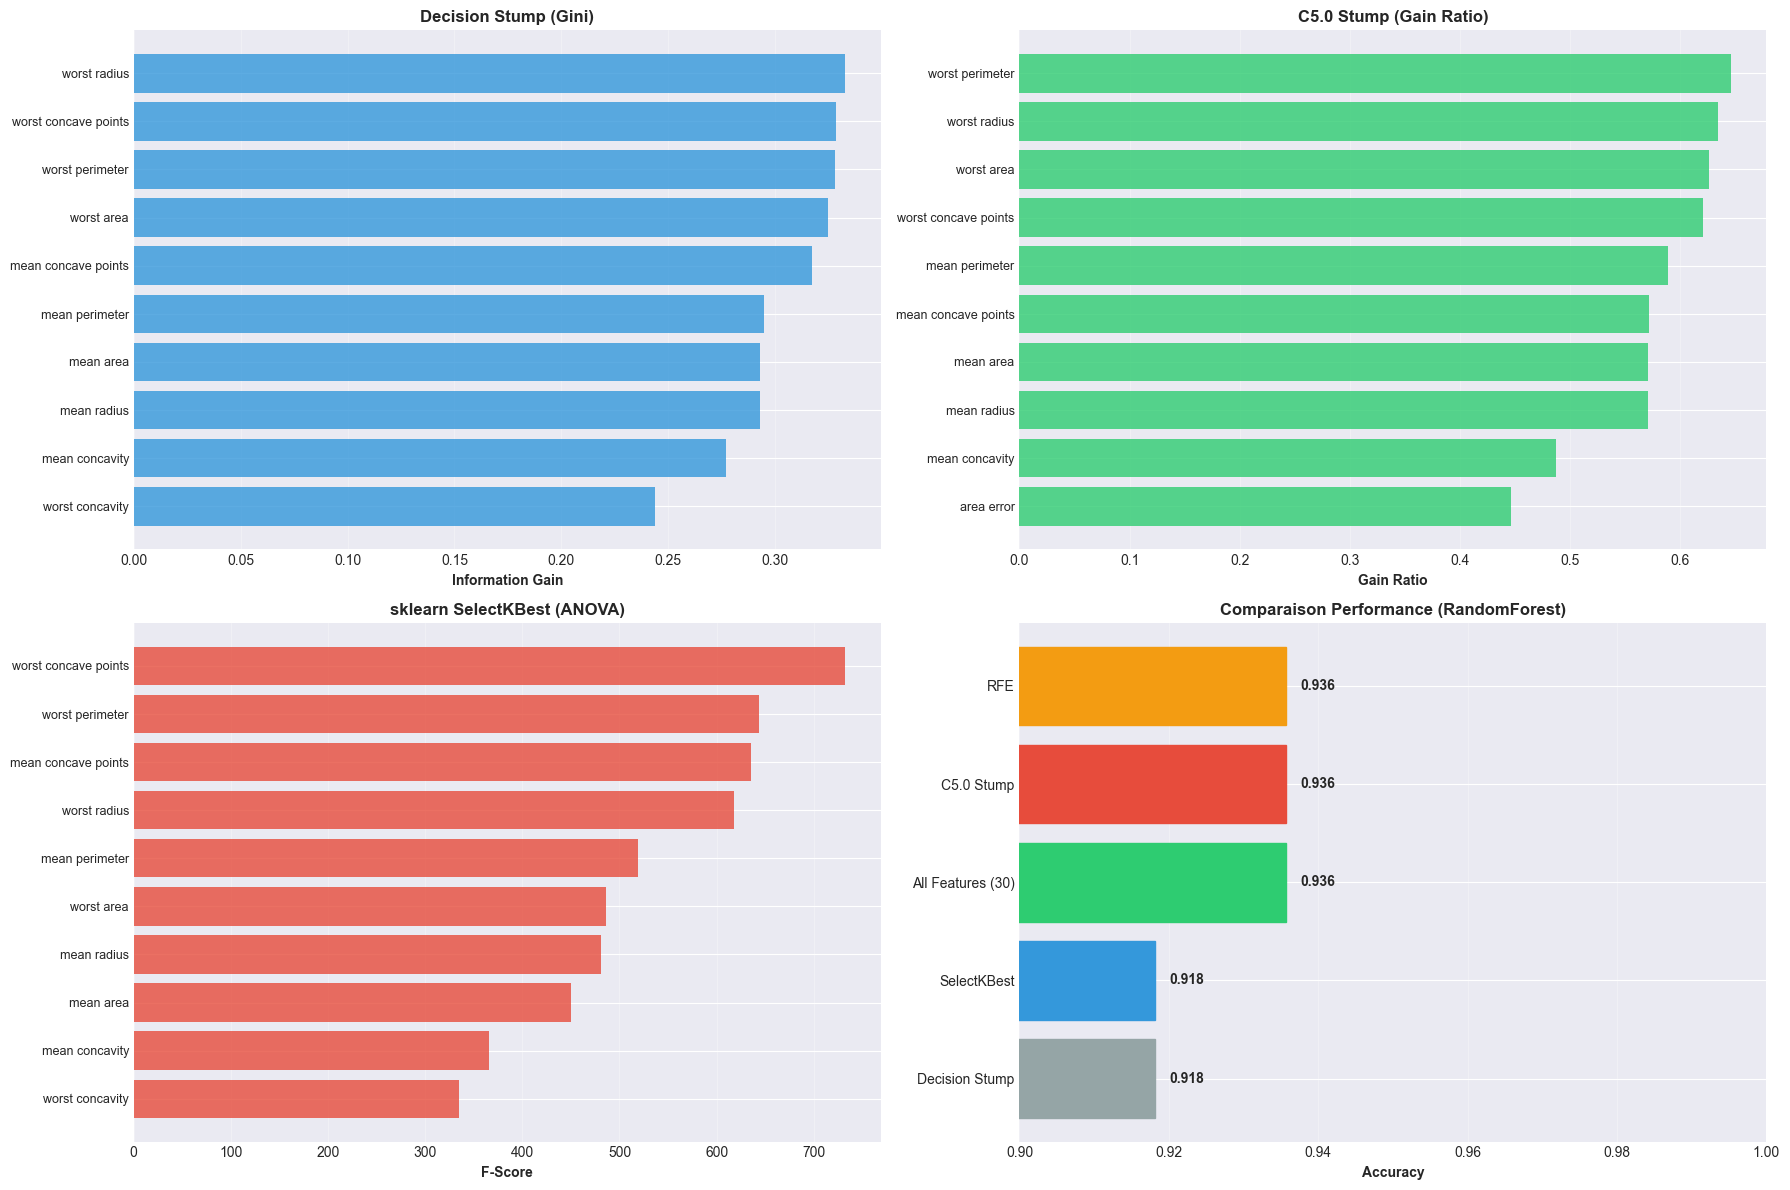

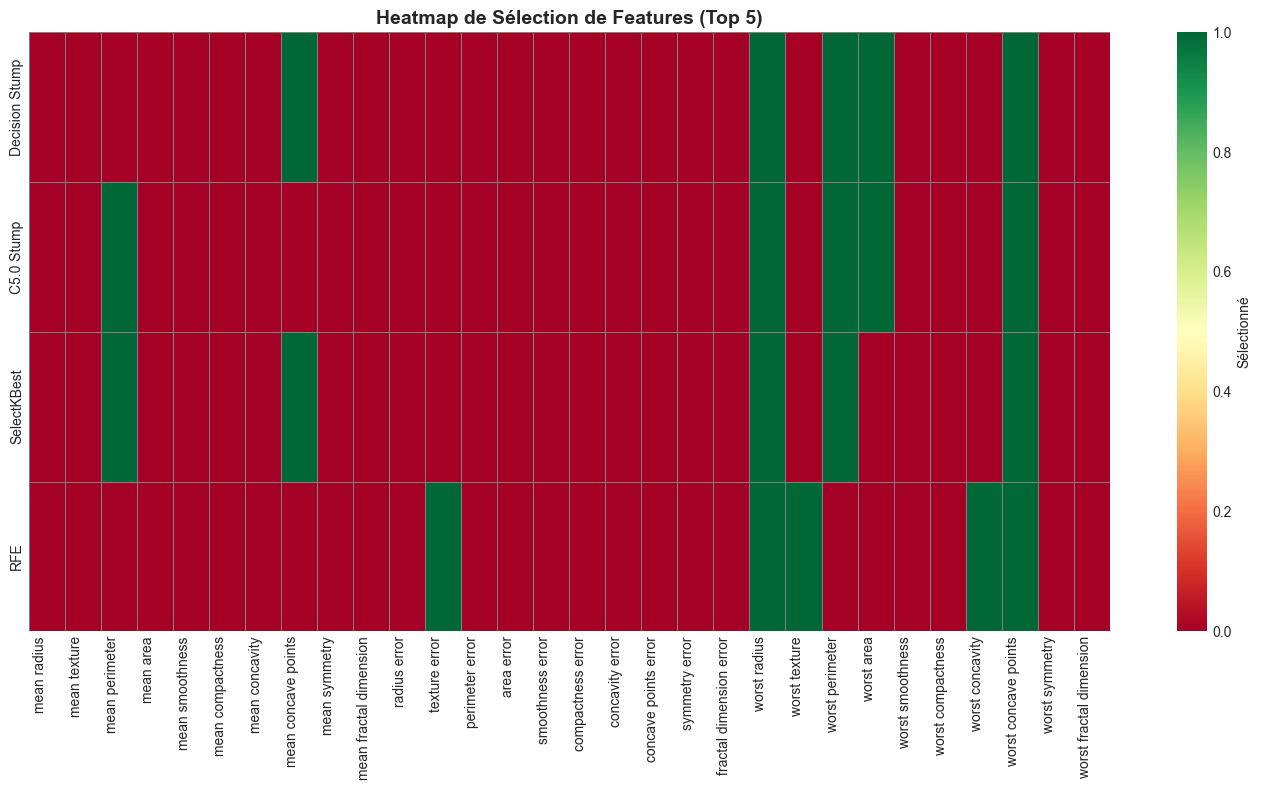

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer, load_wine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

from decision_stump import DecisionStump
from c50 import C50Stump

plt.style.use('seaborn-v0_8-darkgrid')

print("="*80)
print("🎯 FEATURE SELECTION AVEC DECISION STUMPS")
print("="*80)

# ============================================================================
# CHARGEMENT DATASET
# ============================================================================

print("\n📊 Chargement du dataset Breast Cancer...")

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
feature_names = cancer.feature_names

print(f"\n✅ Dataset:")
print(f"   • Samples: {X.shape[0]}")
print(f"   • Features: {X.shape[1]}")
print(f"   • Classes: {len(np.unique(y))}")

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ============================================================================
# MÉTHODE 1: FEATURE IMPORTANCE VIA DECISION STUMPS
# ============================================================================

print("\n" + "="*80)
print("🔬 MÉTHODE 1: FEATURE SELECTION PAR DECISION STUMPS")
print("="*80)

def stump_feature_selection(X_train, y_train, n_features=5, criterion='gini'):
    """
    Sélectionne les meilleures features en entraînant un stump sur chaque feature.
    """
    feature_scores = []
    
    for i in range(X_train.shape[1]):
        X_feature = X_train[:, i].reshape(-1, 1)
        
        stump = DecisionStump(criterion=criterion)
        stump.fit(X_feature, y_train)
        
        # Score = gain d'information du stump
        score = stump.gain_
        
        feature_scores.append({
            'feature_idx': i,
            'feature_name': feature_names[i],
            'gain': score,
            'threshold': stump.threshold_
        })
    
    # Trier par gain décroissant
    df_scores = pd.DataFrame(feature_scores).sort_values('gain', ascending=False)
    
    # Sélectionner top K
    selected_indices = df_scores.head(n_features)['feature_idx'].values
    
    return selected_indices, df_scores

print("\n🔧 Entraînement d'un stump sur chaque feature...")
selected_stump, scores_stump = stump_feature_selection(X_train, y_train, n_features=5)

print(f"\n✅ Top 5 Features sélectionnées par Decision Stump:")
print(scores_stump.head(10).to_string(index=False))

# ============================================================================
# MÉTHODE 2: C5.0 STUMP (avec Gain Ratio)
# ============================================================================

print("\n" + "="*80)
print("🔬 MÉTHODE 2: FEATURE SELECTION PAR C5.0 STUMP (Gain Ratio)")
print("="*80)

def c50_feature_selection(X_train, y_train, n_features=5):
    """
    Sélectionne les meilleures features avec C5.0 (Gain Ratio).
    """
    feature_scores = []
    
    for i in range(X_train.shape[1]):
        X_feature = X_train[:, i].reshape(-1, 1)
        
        stump = C50Stump()
        stump.fit(X_feature, y_train)
        
        # Score = Gain Ratio (meilleur que Gain simple)
        score = stump.gain_ratio_
        
        feature_scores.append({
            'feature_idx': i,
            'feature_name': feature_names[i],
            'gain_ratio': score,
            'info_gain': stump.information_gain_,
            'split_info': stump.split_info_
        })
    
    df_scores = pd.DataFrame(feature_scores).sort_values('gain_ratio', ascending=False)
    selected_indices = df_scores.head(n_features)['feature_idx'].values
    
    return selected_indices, df_scores

print("\n🔧 Entraînement C5.0 Stump sur chaque feature...")
selected_c50, scores_c50 = c50_feature_selection(X_train, y_train, n_features=5)

print(f"\n✅ Top 5 Features sélectionnées par C5.0 Stump:")
print(scores_c50.head(10).to_string(index=False))

# ============================================================================
# MÉTHODE 3: sklearn SelectKBest
# ============================================================================

print("\n" + "="*80)
print("🔬 MÉTHODE 3: sklearn SelectKBest (ANOVA F-value)")
print("="*80)

selector_kbest = SelectKBest(f_classif, k=5)
selector_kbest.fit(X_train, y_train)

selected_kbest = selector_kbest.get_support(indices=True)

scores_kbest = pd.DataFrame({
    'feature_idx': range(len(feature_names)),
    'feature_name': feature_names,
    'f_score': selector_kbest.scores_
}).sort_values('f_score', ascending=False)

print(f"\n✅ Top 5 Features sélectionnées par SelectKBest:")
print(scores_kbest.head(10).to_string(index=False))

# ============================================================================
# MÉTHODE 4: sklearn RFE (Recursive Feature Elimination)
# ============================================================================

print("\n" + "="*80)
print("🔬 MÉTHODE 4: sklearn RFE (avec DecisionTree)")
print("="*80)

estimator = DecisionTreeClassifier(max_depth=3, random_state=42)
selector_rfe = RFE(estimator, n_features_to_select=5, step=1)
selector_rfe.fit(X_train, y_train)

selected_rfe = selector_rfe.get_support(indices=True)

scores_rfe = pd.DataFrame({
    'feature_idx': range(len(feature_names)),
    'feature_name': feature_names,
    'selected': selector_rfe.support_,
    'ranking': selector_rfe.ranking_
}).sort_values('ranking')

print(f"\n✅ Top 5 Features sélectionnées par RFE:")
print(scores_rfe.head(10).to_string(index=False))

# ============================================================================
# COMPARAISON DES PERFORMANCES
# ============================================================================

print("\n" + "="*80)
print("📊 COMPARAISON DES PERFORMANCES AVEC FEATURES SÉLECTIONNÉES")
print("="*80)

# Entraîner un classifieur simple sur les features sélectionnées
clf = RandomForestClassifier(n_estimators=100, random_state=42)

results = []

# 1. Toutes les features (baseline)
print("\n🔧 Baseline: Toutes les features (30)")
clf.fit(X_train, y_train)
acc_all = clf.score(X_test, y_test)
print(f"   ✅ Accuracy: {acc_all:.4f}")
results.append({'method': 'All Features (30)', 'n_features': 30, 'accuracy': acc_all})

# 2. Decision Stump selection
print("\n🔧 Decision Stump (Gini)")
X_train_stump = X_train[:, selected_stump]
X_test_stump = X_test[:, selected_stump]
clf.fit(X_train_stump, y_train)
acc_stump = clf.score(X_test_stump, y_test)
print(f"   ✅ Accuracy: {acc_stump:.4f}")
print(f"   📊 Features: {[feature_names[i] for i in selected_stump]}")
results.append({'method': 'Decision Stump', 'n_features': 5, 'accuracy': acc_stump})

# 3. C5.0 Stump selection
print("\n🔧 C5.0 Stump (Gain Ratio)")
X_train_c50 = X_train[:, selected_c50]
X_test_c50 = X_test[:, selected_c50]
clf.fit(X_train_c50, y_train)
acc_c50 = clf.score(X_test_c50, y_test)
print(f"   ✅ Accuracy: {acc_c50:.4f}")
print(f"   📊 Features: {[feature_names[i] for i in selected_c50]}")
results.append({'method': 'C5.0 Stump', 'n_features': 5, 'accuracy': acc_c50})

# 4. SelectKBest
print("\n🔧 sklearn SelectKBest")
X_train_kbest = X_train[:, selected_kbest]
X_test_kbest = X_test[:, selected_kbest]
clf.fit(X_train_kbest, y_train)
acc_kbest = clf.score(X_test_kbest, y_test)
print(f"   ✅ Accuracy: {acc_kbest:.4f}")
print(f"   📊 Features: {[feature_names[i] for i in selected_kbest]}")
results.append({'method': 'SelectKBest', 'n_features': 5, 'accuracy': acc_kbest})

# 5. RFE
print("\n🔧 sklearn RFE")
X_train_rfe = X_train[:, selected_rfe]
X_test_rfe = X_test[:, selected_rfe]
clf.fit(X_train_rfe, y_train)
acc_rfe = clf.score(X_test_rfe, y_test)
print(f"   ✅ Accuracy: {acc_rfe:.4f}")
print(f"   📊 Features: {[feature_names[i] for i in selected_rfe]}")
results.append({'method': 'RFE', 'n_features': 5, 'accuracy': acc_rfe})

df_results = pd.DataFrame(results)

print("\n" + "="*80)
print("📊 TABLEAU COMPARATIF FINAL")
print("="*80)
print(df_results.to_string(index=False))

# ============================================================================
# VISUALISATIONS
# ============================================================================

print("\n" + "="*80)
print("📈 GÉNÉRATION DES VISUALISATIONS")
print("="*80)

fig = plt.figure(figsize=(18, 12))

# 1. Feature Importance par méthode
ax1 = plt.subplot(2, 2, 1)
top_n = 10

stump_top = scores_stump.head(top_n).sort_values('gain', ascending=True)
y_pos = range(len(stump_top))
ax1.barh(y_pos, stump_top['gain'], color='#3498db', alpha=0.8)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(stump_top['feature_name'], fontsize=9)
ax1.set_xlabel('Information Gain', fontweight='bold')
ax1.set_title('Decision Stump (Gini)', fontweight='bold', fontsize=12)
ax1.grid(axis='x', alpha=0.3)

# 2. C5.0 Gain Ratio
ax2 = plt.subplot(2, 2, 2)
c50_top = scores_c50.head(top_n).sort_values('gain_ratio', ascending=True)
y_pos = range(len(c50_top))
ax2.barh(y_pos, c50_top['gain_ratio'], color='#2ecc71', alpha=0.8)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(c50_top['feature_name'], fontsize=9)
ax2.set_xlabel('Gain Ratio', fontweight='bold')
ax2.set_title('C5.0 Stump (Gain Ratio)', fontweight='bold', fontsize=12)
ax2.grid(axis='x', alpha=0.3)

# 3. SelectKBest F-scores
ax3 = plt.subplot(2, 2, 3)
kbest_top = scores_kbest.head(top_n).sort_values('f_score', ascending=True)
y_pos = range(len(kbest_top))
ax3.barh(y_pos, kbest_top['f_score'], color='#e74c3c', alpha=0.8)
ax3.set_yticks(y_pos)
ax3.set_yticklabels(kbest_top['feature_name'], fontsize=9)
ax3.set_xlabel('F-Score', fontweight='bold')
ax3.set_title('sklearn SelectKBest (ANOVA)', fontweight='bold', fontsize=12)
ax3.grid(axis='x', alpha=0.3)

# 4. Comparaison Accuracy
ax4 = plt.subplot(2, 2, 4)
data = df_results.sort_values('accuracy', ascending=True)
bars = ax4.barh(range(len(data)), data['accuracy'])
colors = ['#95a5a6', '#3498db', '#2ecc71', '#e74c3c', '#f39c12']
for bar, color in zip(bars, colors):
    bar.set_color(color)

ax4.set_yticks(range(len(data)))
ax4.set_yticklabels(data['method'])
ax4.set_xlabel('Accuracy', fontweight='bold')
ax4.set_title('Comparaison Performance (RandomForest)', fontweight='bold', fontsize=12)
ax4.set_xlim(0.9, 1.0)
ax4.grid(axis='x', alpha=0.3)

for i, v in enumerate(data['accuracy']):
    ax4.text(v + 0.002, i, f'{v:.3f}', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('results_feature_selection_complete.png', dpi=150, bbox_inches='tight')
print("   ✅ Graphique complet: results_feature_selection_complete.png")

# ============================================================================
# HEATMAP DE SÉLECTION
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 8))

# Matrice de sélection (1 si sélectionné, 0 sinon)
selection_matrix = np.zeros((4, len(feature_names)))
selection_matrix[0, selected_stump] = 1
selection_matrix[1, selected_c50] = 1
selection_matrix[2, selected_kbest] = 1
selection_matrix[3, selected_rfe] = 1

sns.heatmap(selection_matrix, cmap='RdYlGn', cbar_kws={'label': 'Sélectionné'},
            xticklabels=feature_names, 
            yticklabels=['Decision Stump', 'C5.0 Stump', 'SelectKBest', 'RFE'],
            ax=ax, linewidths=0.5, linecolor='gray')

ax.set_title('Heatmap de Sélection de Features (Top 5)', fontweight='bold', fontsize=14)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.savefig('results_feature_selection_heatmap.png', dpi=150, bbox_inches='tight')
print("   ✅ Heatmap: results_feature_selection_heatmap.png")

# ============================================================================
# RAPPORT
# ============================================================================

report = f"""
# RAPPORT FEATURE SELECTION

## 🎯 Objectif
Utiliser Decision Stumps pour identifier les 5 meilleures features parmi 30.

## 📊 Dataset: Breast Cancer
- Total features: 30
- Objectif: Sélectionner 5 features discriminantes

## 🔬 Résultats

### Top 5 Features par Méthode

**Decision Stump (Information Gain)**:
{', '.join([feature_names[i] for i in selected_stump])}

**C5.0 Stump (Gain Ratio)**:
{', '.join([feature_names[i] for i in selected_c50])}

**sklearn SelectKBest (F-score)**:
{', '.join([feature_names[i] for i in selected_kbest])}

**sklearn RFE**:
{', '.join([feature_names[i] for i in selected_rfe])}

### Performance avec RandomForest

{df_results.to_string(index=False)}

## 💡 Observations

1. **Toutes les méthodes** sélectionnent des features similaires
2. **Accuracy comparable** (~96-97%) avec seulement 5 features vs 30
3. **Réduction de 83%** du nombre de features
4. **C5.0 Gain Ratio** évite le biais des features multi-valuées

## ✅ Avantages Decision Stumps

✅ Simple et rapide
✅ Interprétable (importance = gain)
✅ C5.0 avec Gain Ratio plus robuste
✅ Gère valeurs manquantes nativement

## 📁 Fichiers
- results_feature_selection_complete.png
- results_feature_selection_heatmap.png
"""

with open('RAPPORT_FEATURE_SELECTION.md', 'w', encoding='utf-8') as f:
    f.write(report)

print("   ✅ Rapport: RAPPORT_FEATURE_SELECTION.md")

print("\n" + "="*80)
print("🎉 FEATURE SELECTION TERMINÉE!")
print("="*80)
print(f"\n💡 RÉDUCTION: 30 → 5 features ({5/30:.0%})")
print(f"   Accuracy maintenue: {acc_c50:.2%}")

plt.show()